In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd '/content/gdrive/My Drive/CS1951A final/'

/content/gdrive/My Drive/CS1951A final


In [0]:
!ls

labels.json  lemmatized-tokenized.json


In [0]:
import pandas as pd
import numpy as np
import json
import os
from collections import Counter
import random
import matplotlib.pyplot as plt

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.cluster import KMeans, SpectralClustering
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
def sort_dict(mydict):
    for k, v in mydict.items():
        if v is None:
            mydict[k] = 0
    return sorted(mydict.items(), key=lambda k: k[1], reverse=True)

In [0]:
text = json.load(open('lemmatized-tokenized.json'))

In [0]:
career = Counter()
person2career = {}
none = []
for person in text:
    cur = Counter()
    cur['none'] = 0
    for word in text[person]:
        if word in {'actor','actress','film','television','golden','oscar','comedian','show','role','character','host','cast','serie'}:
            cur['actor'] +=1
        if word in {'footballer','football', 'fifa','player','basketball','cup','olympic','wwe','wrestler','team','league','match','score','medal','medalist','boxer','champion','championship'}: 
            cur['sports'] += 1
        if word in {'singer','rapper','musician','album','release','studio','songwriter','music','label','debut','single'}: 
            cur['singers'] += 1
        if word in {'politician','candidate','politic','republican','democrat','campaign','goverment','govern','election','policy','party','governor','president'}:
            cur['politics'] += 1
        if word in {'chairman','ceo','entrepreneur','business','found','billion','heiress','founder','executive','investor','businessman','businesswoman','chief'}:
            cur['business'] += 1
        if word in {'queen','king','princess','prince','empress','monarch','emperor','empire'}:
            cur['royalties'] += 1
        
    person2career[person] = sort_dict(cur)[0][0]
    if person2career[person] is 'none':
        none.append(person)
    career[person2career[person]] += 1
 
print(career)

Counter({'actor': 4841, 'sports': 1663, 'singers': 1435, 'politics': 759, 'business': 458, 'none': 446, 'royalties': 398})


In [0]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels = le.fit_transform(list(person2career.values()))

doc_ids = np.array(list(text.keys()))

In [0]:
def doc2vec(data, doc_ids, embedding_size=50, window_size=2, min_count=1, workers=4):
    docs = list(data.values())
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
    model = Doc2Vec(documents, 
                    vector_size=embedding_size, 
                    window=window_size, 
                    min_count=min_count, 
                    workers=workers)
    return np.array([model.infer_vector(data[key]) for key in doc_ids])

def bags_of_words(data, doc_ids):
    docs = [' '.join(data[key]) for key in doc_ids]
    model = CountVectorizer().fit_transform(docs)
    counts = model.toarray()
    return counts / np.linalg.norm(counts)

def kmeanscluster(vectors, doc_ids, id2doc, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)

    doc_ids_clusters, doc_clusters, variances = [], [], []
    for i in range(n_clusters):
        doc_ids_clusters.append(doc_ids[kmeans.labels_ == i])
        doc_clusters.append([id2doc[key] for key in doc_ids[kmeans.labels_ == i]])
        variances.append(variance(vectors[kmeans.labels_ == i]))
    
    print('cluster variance:', variances)
    print('cluster size:', [len(c) for c in doc_clusters])
    
    return doc_ids_clusters, doc_clusters, list(kmeans.labels_)

def tfidf(data, doc_ids, use_idf=True):
    docs = [' '.join(data[key]) for key in doc_ids]
    model = TfidfVectorizer(use_idf=use_idf).fit_transform(docs)
    counts = model.toarray()
    return counts / np.linalg.norm(counts)

def variance(vectors):
    return np.mean(np.var(vectors, axis=0))

# https://www.datacamp.com/community/tutorials/wordcloud-python
def make_wordcloud(docs):
    wordcloud = WordCloud().generate(' '.join([token for d in docs for token in d]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def show_wordclouds_kmeanscluster(vecs, doc_ids, data, n_clusters):
    id_clusters, doc_clusters, predictions = kmeanscluster(vecs, doc_ids, data, n_clusters=n_clusters)
    for i in range(n_clusters):
        print('Pages in cluster:', [x[6:] for x in id_clusters[i][:10]])
        make_wordcloud(doc_clusters[i])
    return predictions

In [0]:
def spectralcluster(vectors, doc_ids, id2doc, n_clusters=10):
    sepctralclustering = SpectralClustering(
        n_clusters=n_clusters, 
         assign_labels="discretize",
        random_state=0
    ).fit(vectors)

    doc_ids_clusters, doc_clusters, variances = [], [], []
    for i in range(n_clusters):
        doc_ids_clusters.append(doc_ids[sepctralclustering .labels_ == i])
        doc_clusters.append([id2doc[key] for key in doc_ids[sepctralclustering .labels_ == i]])
        variances.append(variance(vectors[sepctralclustering .labels_ == i]))
    
    print('cluster variance:', variances)
    print('cluster size:', [len(c) for c in doc_clusters])
    
    return doc_ids_clusters, doc_clusters, list(sepctralclustering .labels_)

def show_wordclouds_spectralcluster(vecs, doc_ids, data, n_clusters):
    id_clusters, doc_clusters, predictions = spectralcluster(vecs, doc_ids, data, n_clusters=n_clusters)
    for i in range(n_clusters):
        print('Pages in cluster:', [x[6:] for x in id_clusters[i][:10]])
        make_wordcloud(doc_clusters[i])
    return predictions

cluster variance: [0.010680304, 0.04506534, 0.0062089176, 0.04179483, 0.029821483, 0.01703652, 0.03236699, 0.03300269, 0.026500115, 0.025095267]
cluster size: [1821, 245, 3894, 371, 572, 1088, 365, 277, 710, 657]
Pages in cluster: ['Jason_Momoa', 'Anthony_Bourdain', 'Stan_Lee', 'Sylvester_Stallone', 'Jennifer_Aniston', 'Michael_B._Jordan', 'Burt_Reynolds', 'Ryan_Reynolds', 'Chris_Hemsworth', 'Josh_Brolin']


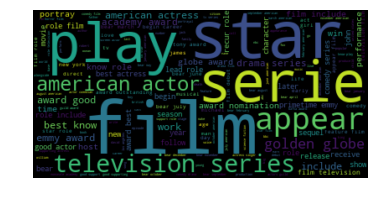

Pages in cluster: ['Elizabeth_II', 'Queen_Victoria', 'Princess_Margaret,_Countess_of_Snowdon', 'George_VI', 'Adolf_Hitler', 'Mary,_Queen_of_Scots', 'Edward_VIII', 'George_V', 'Joseph_Stalin', 'Elizabeth_I_of_England']


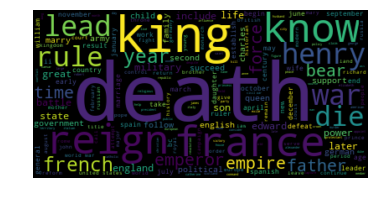

Pages in cluster: ['Louis_Tomlinson', 'Antonio_Maria_Magro', 'Dua_Lipa', 'Pete_Davidson', 'Andrew_Cunanan', 'Hailey_Baldwin', 'Dolores_O%27Riordan', 'John_Paul_Getty_III', 'Lisa_Bonet', 'Beto_O%27Rourke']


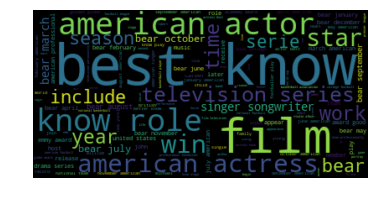

Pages in cluster: ['Donald_Trump', 'George_H._W._Bush', 'John_McCain', 'Winston_Churchill', 'Barack_Obama', 'Brett_Kavanaugh', 'Mahatma_Gandhi', 'George_W._Bush', 'Martin_Luther_King_Jr.', 'John_F._Kennedy']


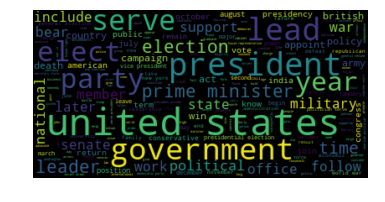

Pages in cluster: ['Cristiano_Ronaldo', 'Lionel_Messi', 'LeBron_James', 'Michael_Jordan', 'Tom_Brady', 'Kylian_Mbapp%C3%A9', 'Mohamed_Salah', 'Virat_Kohli', 'Neymar', 'Stephen_Curry']


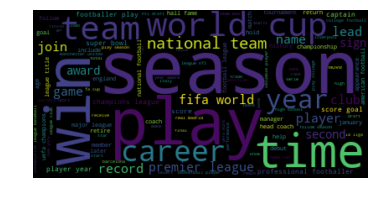

Pages in cluster: ['Meghan,_Duchess_of_Sussex', 'Charles,_Prince_of_Wales', 'Prince_Philip,_Duke_of_Edinburgh', 'Pablo_Escobar', 'Diana,_Princess_of_Wales', 'Prince_William,_Duke_of_Cambridge', 'Gianni_Versace', 'Jeffrey_Dahmer', 'Prince_Harry,_Duke_of_Sussex', 'Arnold_Schwarzenegger']


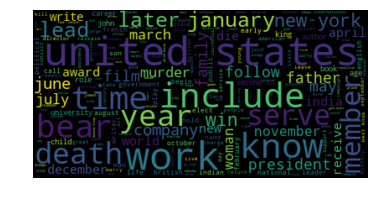

Pages in cluster: ['Elon_Musk', 'Stephen_Hawking', 'P._T._Barnum', 'Albert_Einstein', 'Ted_Kaczynski', 'Steve_Jobs', 'Ted_Bundy', 'William_Shakespeare', 'Bill_Gates', 'Rajneesh']


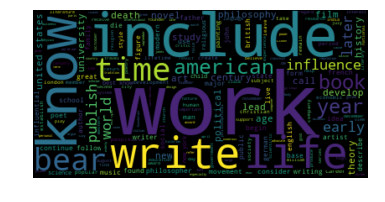

Pages in cluster: ['Dwayne_Johnson', 'Tonya_Harding', 'Khabib_Nurmagomedov', 'Conor_McGregor', 'Roger_Federer', 'John_Cena', 'Anthony_Joshua', 'Serena_Williams', 'Muhammad_Ali', 'Rafael_Nadal']


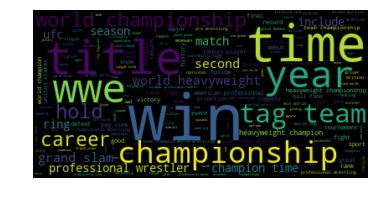

Pages in cluster: ['Cardi_B', 'Freddie_Mercury', 'XXXTentacion', 'Ariana_Grande', '6ix9ine', 'Avicii', 'Donald_Glover', 'Nick_Jonas', 'Post_Malone', 'Michael_Jackson']


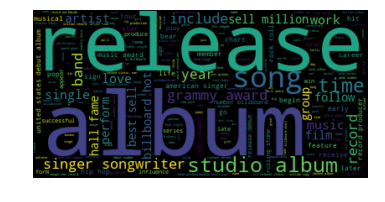

Pages in cluster: ['Priyanka_Chopra', 'Sridevi', 'Tom_Cruise', 'Demi_Lovato', 'Clint_Eastwood', 'Scarlett_Johansson', 'Emily_Blunt', 'Keanu_Reeves', 'Tom_Hardy', 'Jennifer_Lawrence']


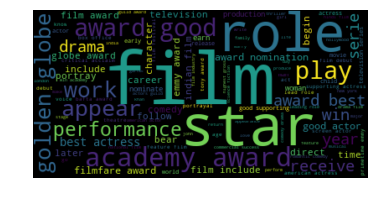

In [0]:
n_clusters = 10

# doc2vec
d2v_vecs = doc2vec(text, doc_ids)
predictions = show_wordclouds_spectralcluster(d2v_vecs, doc_ids, text, n_clusters)

In [0]:
correct = Counter()
wrong = Counter()
total = Counter()
l = list(le.classes_)

for i,p in enumerate(predictions):
    if p in {0, 2, 9}: #actor
        if labels[i] == 0:
            correct[l[0]] += 1
        elif labels[i] != 2:
            wrong[l[0]] += 1
        total[l[0]] += 1
    if p == 6: #business
        if labels[i] == 1:
            correct[l[1]] += 1
        elif labels[i] != 2:
            wrong[l[1]] += 1
        total[l[1]] += 1
    if p == 3: #politics
        if labels[i] == 3:
            correct[l[3]] += 1
        elif labels[i] != 2:
            wrong[l[3]] += 1 
        total[l[3]] += 1
    if p == 8: #singers
        if labels[i] == 5:
            correct[l[5]] += 1
        elif labels[i] != 2:
            wrong[l[5]] += 1  
        total[l[5]] += 1
    if p in {1,5}: #royalties
        if labels[i] == 4:
            correct[l[4]] += 1
        elif labels[i] != 2:
            wrong[l[4]] += 1  
        total[l[4]] += 1
    if p in {4,7}: #sports
        if labels[i] == 6:
            correct[l[6]] += 1
        elif labels[i] != 2:
            wrong[l[6]] += 1
        total[l[6]] += 1
print('Correct:', correct)
print('Wrong:', wrong)
print('Total accuracy: ', (sum(correct.values())/10000))
for c in l:
    if c != 'none':
        print('accuracy for %s: %.4f' % (c, correct[c]/total[c]))

Correct: Counter({'actor': 4513, 'sports': 840, 'singers': 667, 'politics': 324, 'royalties': 278, 'business': 81})
Wrong: Counter({'actor': 1664, 'royalties': 871, 'business': 226, 'politics': 41, 'singers': 40, 'sports': 9})
Total accuracy:  0.6703
accuracy for actor: 0.7083
accuracy for business: 0.2219
accuracy for politics: 0.8733
accuracy for royalties: 0.2086
accuracy for singers: 0.9394
accuracy for sports: 0.9894


cluster variance: [3.0860084330643617e-09, 4.6035753544980074e-10, 2.6056339291600003e-09, 3.308058140280451e-09, 1.5458475686717288e-09, 1.7836529727893903e-09, 2.1540748564369124e-09, 2.3162605928078174e-09, 1.067265436367883e-09, 1.6221644507627243e-09]
cluster size: [987, 3474, 377, 602, 715, 507, 470, 727, 1349, 792]
Pages in cluster: ['Elizabeth_II', 'Freddie_Mercury', 'Elon_Musk', 'Stephen_Hawking', 'Anthony_Bourdain', 'Queen_Victoria', 'Stan_Lee', 'Princess_Margaret,_Countess_of_Snowdon', 'Charles,_Prince_of_Wales', 'Prince_Philip,_Duke_of_Edinburgh']


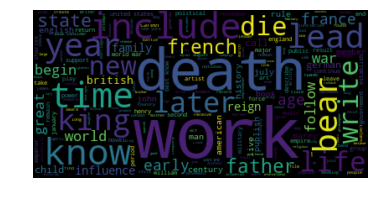

Pages in cluster: ['Antonio_Maria_Magro', 'Pete_Davidson', 'Andrew_Cunanan', 'Gianni_Versace', 'Hailey_Baldwin', 'Jeffrey_Dahmer', 'Dolores_O%27Riordan', 'John_Paul_Getty_III', 'Lisa_Bonet', 'Chadwick_Boseman']


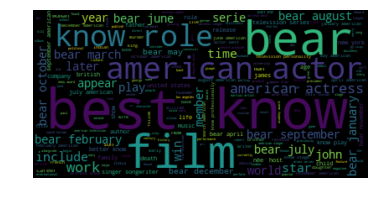

Pages in cluster: ['Dwayne_Johnson', 'Tonya_Harding', 'Jeff_Bezos', 'Khabib_Nurmagomedov', 'Conor_McGregor', 'Roger_Federer', 'John_Cena', 'Anthony_Joshua', 'Serena_Williams', 'Muhammad_Ali']


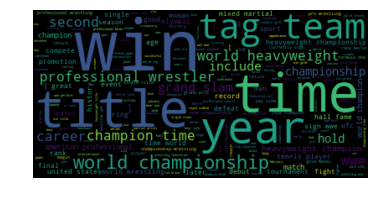

Pages in cluster: ['Donald_Trump', 'George_H._W._Bush', 'John_McCain', 'Winston_Churchill', 'Barack_Obama', 'P._T._Barnum', 'Brett_Kavanaugh', 'George_W._Bush', 'John_F._Kennedy', 'Abraham_Lincoln']


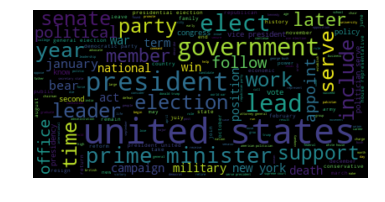

Pages in cluster: ['Tom_Cruise', 'Demi_Lovato', 'Scarlett_Johansson', 'Emily_Blunt', 'Bradley_Cooper', 'Leonardo_DiCaprio', 'Rami_Malek', 'Ellen_DeGeneres', 'Elizabeth_Olsen', 'Robin_Williams']


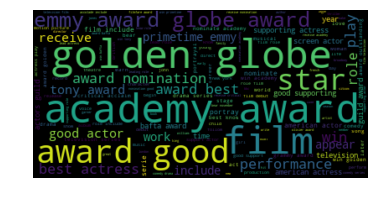

Pages in cluster: ['LeBron_James', 'Michael_Jordan', 'Tom_Brady', 'Stephen_Curry', 'Shaquille_O%27Neal', 'Kobe_Bryant', 'Nick_Foles', 'O._J._Simpson', 'Kevin_Durant', 'Patrick_Mahomes']


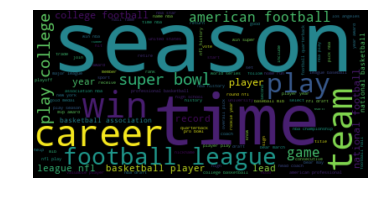

Pages in cluster: ['Cristiano_Ronaldo', 'Lionel_Messi', 'Kylian_Mbapp%C3%A9', 'Mohamed_Salah', 'Virat_Kohli', 'Neymar', 'Harry_Kane', 'Zlatan_Ibrahimovi%C4%87', 'David_Beckham', 'Pel%C3%A9']


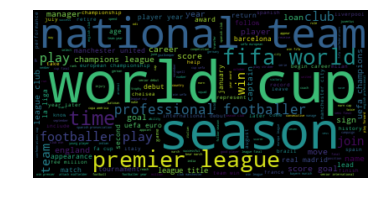

Pages in cluster: ['Cardi_B', 'Louis_Tomlinson', 'XXXTentacion', 'Ariana_Grande', '6ix9ine', 'Avicii', 'Donald_Glover', 'Nick_Jonas', 'Post_Malone', 'Michael_Jackson']


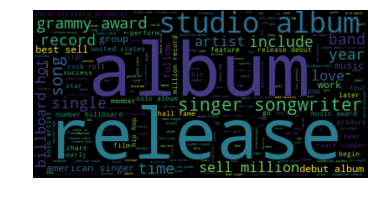

Pages in cluster: ['Meghan,_Duchess_of_Sussex', 'Jennifer_Aniston', 'Kylie_Jenner', 'Michael_B._Jordan', 'Burt_Reynolds', 'John_Krasinski', 'Tom_Hardy', 'Chris_Pratt', 'Jennifer_Lawrence', 'Fred_Rogers']


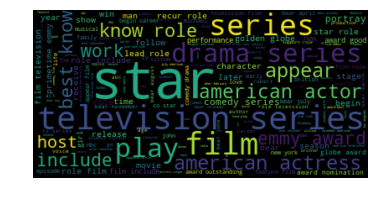

Pages in cluster: ['Jason_Momoa', 'Priyanka_Chopra', 'Sridevi', 'Sylvester_Stallone', 'Clint_Eastwood', 'Ryan_Reynolds', 'Chris_Hemsworth', 'Josh_Brolin', 'Keanu_Reeves', 'Mila_Kunis']


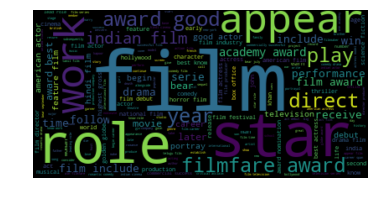

In [0]:
n_clusters = 10

# doc2vec
bow_vecs = bags_of_words(text, doc_ids)
predictions = show_wordclouds_spectralcluster(bow_vecs, doc_ids, text, n_clusters)

In [0]:
correct = Counter()
wrong = Counter()
total = Counter()
l = list(le.classes_)

for i,p in enumerate(predictions):
    if p in {1, 4, 8,9}: #actor
        if labels[i] == 0:
            correct[l[0]] += 1
        elif labels[i] != 2:
            wrong[l[0]] += 1
        total[l[0]] += 1
    if p == 0: #other
        if labels[i] in {1, 4, 2}:
            correct[l[labels[i]]] += 1
        else:
            wrong[l[labels[i]]] += 1
        total[l[labels[i]]] += 1
    if p == 3: #politics
        if labels[i] == 3:
            correct[l[3]] += 1
        elif labels[i] != 2:
            wrong[l[3]] += 1 
        total[l[3]] += 1
    if p == 7: #singers
        if labels[i] == 5:
            correct[l[5]] += 1
        elif labels[i] != 2:
            wrong[l[5]] += 1  
        total[l[5]] += 1
    if p in {2,5,6}: #sports
        if labels[i] == 6:
            correct[l[6]] += 1
        elif labels[i] != 2:
            wrong[l[6]] += 1
        total[l[6]] += 1
print('Correct:', correct)
print('Wrong:', wrong)
print('Total accuracy: ', (sum(correct.values())/10000))
for c in l:
    if c != 'none':
        print('accuracy within the cluster for %s: %.4f' % (c, correct[c]/total[c]))
        print('accuracy with the true labels for %s: %.4f' % (c, correct[c]/career[c]))

Correct: Counter({'actor': 4632, 'sports': 1320, 'singers': 721, 'politics': 500, 'royalties': 285, 'none': 115, 'business': 113})
Wrong: Counter({'actor': 1533, 'politics': 218, 'singers': 160, 'sports': 72})
Total accuracy:  0.7686
accuracy within the cluster for actor: 0.7139
accuracy with the true labels for actor: 0.9568
accuracy within the cluster for business: 1.0000
accuracy with the true labels for business: 0.2467
accuracy within the cluster for politics: 0.6897
accuracy with the true labels for politics: 0.6588
accuracy within the cluster for royalties: 1.0000
accuracy with the true labels for royalties: 0.7161
accuracy within the cluster for singers: 0.8184
accuracy with the true labels for singers: 0.5024
accuracy within the cluster for sports: 0.9476
accuracy with the true labels for sports: 0.7937
